<a href="https://colab.research.google.com/github/uol-mediaprocessing-202021/medienverarbeitung-i-how-is-my-plant-doing/blob/kian/%7BEfficentNET_B1%7D_PRE_PROCESSING_PIPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# DELETE EVEREYTHING
! rm -rf *

In [ ]:
%%bash
# Download the Video from Server

PLANTS=('basilikum' 'petersilie')
STATES=('1' '2')
SERVER_URL='https://video.natgo.dev/'

# Create plants folder
mkdir plants
cd plants

for plant in "${PLANTS[@]}";do
  for state in "${STATES[@]}";do
    wget "$SERVER_URL$plant$state.mp4"
    mkdir $plant$state
  done
done




In [4]:
# imports
import cv2 as cv2
import numpy as np


In [5]:
# CONSTANTS
BLURRYNESS_THRESHOLD = 50 #@param {type: 'slider', min: 0, max: 150}
HSV_LIGHT_GREEN = (30,100, 80)
HSV_DARK_GREEN = (105,255,255)
PLANT_DIR = 'plants'

# FUNCTIONS #
def variance_of_laplacian(image):
	# compute the Laplacian of the image and then return the focus
	# measure, which is simply the variance of the Laplacian
	return cv2.Laplacian(image, cv2.CV_64F).var()
 
def resize_img_to_percent(img, percent):
  scale_percent = percent # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized

# Maskingfunction
def create_green_mask(img):
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_image, HSV_LIGHT_GREEN, HSV_DARK_GREEN)
    return cv2.bitwise_and(img, img, mask=mask)

def process_video(video, plant, state):
  index = 0
  while(video.isOpened()):
    ret, frame = video.read()
    if not ret:
      break
    # Every n Frame for testing
    if plant == 'petersilie':
      every_n_frame = 3
    elif plant == 'basilikum':
      every_n_frame = 5
    if index % every_n_frame == 0:
      # Check for blurrynes
      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      focus_measure = variance_of_laplacian(gray)
      if focus_measure > BLURRYNESS_THRESHOLD:
        # resize image
        frame = resize_img_to_percent(frame, 50)
        # mask image
        # frame = create_green_mask(frame)
        # canny the image
        # frame = cv2.Canny(frame,100,200)
        cv2.imwrite(f'./{PLANT_DIR}/{plant}{state}/{plant}{index}.jpg', frame)
      else:
        print(f'{plant} # {state} Frame #{index}: Too blurry! Focus Measure: {focus_measure}')
    index += 1



In [6]:

# Iterate over videos and process them
plants = ['basilikum', 'petersilie']
states = [1, 2]

for plant in plants:
  for state in states:
    video = cv2.VideoCapture(f'./{PLANT_DIR}/{plant}{state}.mp4')
    process_video(video, plant, state)

    

basilikum # 2 Frame #115: Too blurry! Focus Measure: 46.51065704541617
basilikum # 2 Frame #550: Too blurry! Focus Measure: 49.54657111160369
basilikum # 2 Frame #555: Too blurry! Focus Measure: 42.568040106709795
basilikum # 2 Frame #560: Too blurry! Focus Measure: 44.46818750450228
basilikum # 2 Frame #570: Too blurry! Focus Measure: 49.006073705855705


In [7]:
#K Fold Generierung 
import json
import os
import random
from math import floor  
from shutil import copy2 

class KFoldGenerator():
  def __init__(self,data_dir,plants):
      self.RS = 96
      random.seed = self.RS
      self.plants = plants
      self.data_dir = data_dir
      self.nr_classes = len(plants)*3 
      self.dir_list = [dir for dir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,dir))]
      if '.ipynb_checkpoints' in self.dir_list : 
        self.dir_list.remove('.ipynb_checkpoints')
      self.plant_nrs = []
      for plant in plants:
          nrs = sorted([int(dir.replace(plant,'')) for dir in self.dir_list if plant in dir])
          self.plant_nrs.append(nrs)
      self.class_dict = {}
      for i,plant in enumerate(self.plants):
          nrs = self.plant_nrs[i]
          self.class_dict.update({
            f'{plant}{nrs[0]}' : f'_class_{plant}_frisch',
            f'{plant}{nrs[1]}' : f'_class_{plant}_trocken',
          })
      
      filepaths = self.__load_paths__()
      self.filepaths = self.__set_class__(filepaths)
      
  def __load_paths__(self):
      all_paths = []
      for dir in self.dir_list:
         dir_path = os.path.join(self.data_dir,dir) 
         paths = [os.path.join(dir_path,file) for file in os.listdir(dir_path)]
         all_paths.extend(paths)
      return all_paths 
  
  def __set_class__(self,files):
    classes = []
    for file in files:
      dir = os.path.dirname(file)
      self.class_dict.get(os.path.basename(os.path.normpath(dir)))
      tup = (file,self.class_dict.get(os.path.basename(os.path.normpath(dir))))
      classes.append(tup) 
    random.shuffle(classes)
    return classes
      
  def generate_k_folds(self,k):
    copy_list = self.filepaths[:]
    test_size = floor(len(self.filepaths)/k)
    rest = len(self.filepaths)%k
    folds = []
    for i in range(0,k):
      if i == k-1:
        test_size = test_size + rest
      folds.append(self.__generate_fold__(copy_list,test_size))
    dir_kfolds = 'K_FOLDS'  
    os.mkdir('K_FOLDS')
    for i,fold in enumerate(folds):
      current_fold = f'{dir_kfolds}/Fold{i+1}'
      train = fold[0]
      test = fold[1]
      print(test)  
      os.mkdir(current_fold)
      test_dir = f'{current_fold}/test'
      train_dir = f'{current_fold}/train'
      os.mkdir(test_dir)
      os.mkdir(train_dir)  
      self.__copy_list_to_dir__(test,test_dir)
      self.__copy_list_to_dir__(train,train_dir)

  def __generate_fold__(self,liste,size):
    test = []
    while len(test)<size:
      test_item = random.choice(liste)
      test.append(test_item)
      liste.remove(test_item)
    train = [file for file in self.filepaths if file not in test ]
    return (train, test)

  def __copy_list_to_dir__(self,list,dir):  
    print(dir)
    for item in list:
      src = item[0]
      label = item[1]
      file_info = os.path.splitext(os.path.basename(src))
      dst = f'{dir}/{file_info[0]}{label}{file_info[1]}'
      copy2(src = src,dst = dst)


K_FOLDS = 5
PLANTS = ['basilikum', 'petersilie']
DIR ='plants'
gen = KFoldGenerator(DIR,PLANTS)
gen.generate_k_folds(K_FOLDS)

[('plants/basilikum1/basilikum945.jpg', '_class_basilikum_frisch'), ('plants/petersilie1/petersilie138.jpg', '_class_petersilie_frisch'), ('plants/basilikum1/basilikum1635.jpg', '_class_basilikum_frisch'), ('plants/basilikum1/basilikum1440.jpg', '_class_basilikum_frisch'), ('plants/basilikum2/basilikum1410.jpg', '_class_basilikum_trocken'), ('plants/petersilie1/petersilie240.jpg', '_class_petersilie_frisch'), ('plants/petersilie1/petersilie783.jpg', '_class_petersilie_frisch'), ('plants/basilikum2/basilikum195.jpg', '_class_basilikum_trocken'), ('plants/basilikum2/basilikum140.jpg', '_class_basilikum_trocken'), ('plants/petersilie1/petersilie663.jpg', '_class_petersilie_frisch'), ('plants/petersilie1/petersilie372.jpg', '_class_petersilie_frisch'), ('plants/basilikum1/basilikum655.jpg', '_class_basilikum_frisch'), ('plants/petersilie1/petersilie576.jpg', '_class_petersilie_frisch'), ('plants/petersilie1/petersilie765.jpg', '_class_petersilie_frisch'), ('plants/basilikum2/basilikum1285.

In [8]:
# Training der Netze
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import (array_to_img, img_to_array,
                                                  load_img)
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import re
import matplotlib.pyplot as plt

IMG_H = 240
IMG_W = 240
IMG_C = 3

K_DIR = 'K_FOLDS'
RES_DIR = 'results'
NUM_LABELS = len(gen.class_dict)
dict_values = list(gen.class_dict.values())
print(NUM_LABELS,dict_values)
folds  = os.listdir(K_DIR) 

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

sorted = folds.sort(key = natural_keys) 

def get_file_list(dir):
    #Liste mit kompletten Pfaden der Bilder
    return [os.path.join(dir,bild) for bild in os.listdir(dir)]
def get_labels(bilder):
    matching_dict = ['_'+ os.path.basename(bild).split('_',1)[1].replace('.jpg','') for bild in bilder]
    labels = np.array([dict_values.index(matching_str) for matching_str in matching_dict])
    return to_categorical(labels,NUM_LABELS)
def get_images(bilder):
    num_images = len(bilder)
    images = np.empty((num_images,IMG_H,IMG_W,IMG_C),dtype = np.float32)
    for i,bild in enumerate(bilder):
      image = load_img(bild, target_size = (IMG_H,IMG_W))
      image = img_to_array(image)
      image/=255
      images[i,:,:,:] = image
    return images


def get_model_custom():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(IMG_H,IMG_W,IMG_C)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation="relu"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation="relu"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dense(NUM_LABELS, activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])
    return model

class Generator(tf.keras.utils.Sequence):
    def __init__(self,img_files,batch_size):
        self.batch_size = batch_size
        self.batches = int(len(img_files)/batch_size)
        self.img_files = img_files
        self.imgs = len(img_files)
        self.rest = self.imgs-self.batches * self.batch_size
    def __len__(self):
        if len(self.img_files)%self.batch_size == 0 : return self.batches
        elif len(self.img_files)%self.batch_size>0 :return self.batches+1 
        
                   
    def __getitem__(self,idx):
        
        start_index = idx * self.batch_size
        if idx < self.batches:
            last_index = (idx+1) *self.batch_size   
        else :
            if self.rest >0 : last_index = self.imgs
            else: last_index = (idx+1)*self.batch_size
        if start_index == last_index : last_index = start_index +1 
        current = self.img_files[start_index: last_index]
        
        X = get_images(current)
        y = get_labels(current)
        print(' ',self.imgs,'start',start_index,'end',last_index)
        return X,y 
    
    def on_epoch_end(self):
        random.shuffle(self.img_files)

def get_model_Effi():

  # Adam 
  adam = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    name='Adam')


  img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
  )

  NUM_CLASSES = 4

  inputs = layers.Input(shape=(IMG_H, IMG_W, 3))
  x = img_augmentation(inputs)
  outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
      optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"]
  )

  model.summary()
  return model


#Folditeration

get_model = get_model_Effi#get_model_custom
BATCH_SIZE = 8
EPOCHS = 40
RES_DIR = 'results'
if not os.path.exists(RES_DIR):
    os.mkdir(RES_DIR)

histories = []
len_evals = []

for i,fold in enumerate(folds):
    tf.keras.backend.clear_session()  
    test =  get_file_list(os.path.join(K_DIR,fold,'test'))
    train = get_file_list(os.path.join(K_DIR,fold,'train'))
    y_test = get_labels(test)
    x_test = get_images(test)
    model = get_model()
    sequence = Generator(train, BATCH_SIZE) 
    history = model.fit(sequence, epochs = EPOCHS, validation_data = (x_test,y_test))
    model.save(f'{RES_DIR}/k{i+1}.h5')
    len_evals.append(len(test))
    histories.append(history.history)


Streaming output truncated to the last 5000 lines.
130/130 [==============================] - 22s 173ms/step - loss: 1.3146 - accuracy: 0.5991 - val_loss: 2.1547 - val_accuracy: 0.2317
Epoch 4/40
  1036 start 624 end 632
  1036 start 536 end 544
130/130 [==============================] - 23s 175ms/step - loss: 1.0837 - accuracy: 0.5874 - val_loss: 1.6648 - val_accuracy: 0.2548
Epoch 5/40
  1036 start 608 end 616
  1036 start 824 end 832
130/130 [==============================] - 23s 175ms/step - loss: 0.8776 - accuracy: 0.6607 - val_loss: 2.2821 - val_accuracy: 0.2587
Epoch 6/40
  1036 start 688 end 696
  1036 start 616 end 624
130/130 [==============================] - 23s 175ms/step - loss: 0.7397 - accuracy: 0.7426 - val_loss: 3.5502 - val_accuracy: 0.2664
Epoch 7/40
  1036 start 128 end 136
  1036 start 680 end 688
 76/130 [================>.............] - ETA: 9s - loss: 0.7264 - accuracy: 0.7272  1036 start 96 end 104
  1036 start 872 end 880
130/130 [===========================

5 5
LEN 259 259 259
        loss  accuracy   val_loss  val_accuracy
0   2.998530  0.376255   2.884206      0.261776
1   2.012020  0.471236   2.020738      0.262548
2   1.382802  0.539961   1.675205      0.267181
3   1.164173  0.583977   1.714255      0.243243
4   0.912019  0.661583   2.078229      0.227799
5   0.719447  0.755019   5.509409      0.427799
6   0.628809  0.792085   0.522771      0.819305
7   0.509745  0.837838   1.733826      0.804633
8   0.477955  0.849228   1.541464      0.661004
9   0.353707  0.882819   0.438362      0.850193
10  0.332182  0.888031   1.890514      0.744402
11  0.338638  0.894015   1.686400      0.783784
12  0.287475  0.905212   0.209863      0.941313
13  0.303591  0.902317   1.838395      0.793050
14  0.248111  0.918147   0.488125      0.850965
15  0.222743  0.927413   0.713855      0.827799
16  0.225761  0.929730  10.524197      0.715058
17  0.228854  0.930695   0.599374      0.873359
18  0.174010  0.944981   0.662781      0.844015
19  0.141641  0.9552

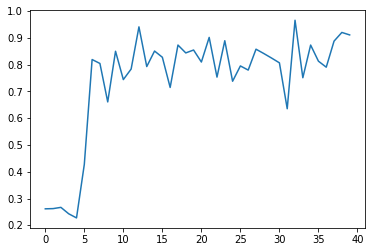

In [9]:
import pandas as pd
historys = [pd.DataFrame(history) for history in histories]
print(len(historys),len(len_evals))
print('LEN',len_evals[0],len_evals[1],len_evals[2])

def average_metrics(historys,k,weights):
    summe = sum(weights)
    average = pd.DataFrame(data = np.zeros(shape = historys[0].shape,dtype = np.float32), columns = historys[0].columns)
    for i, history in enumerate(historys):
       average = average.add(history.apply(lambda x: x*weights[i]/summe))

    return  average

average = average_metrics(historys,K_FOLDS,len_evals)
print(average)
fig,ax = plt.subplots(1)
ax.plot(average['val_accuracy'])
plt.show()



In [10]:
import tensorflow as tf


for i in range(1,6):
  path = f'results/k{i}.h5'
  converter = tf.lite.TFLiteConverter.from_keras_model(tf.keras.models.load_model(path))
  tflite_model = converter.convert()
  # Save the model.
  with open(f'k{i}.tflite', 'wb') as f:
    f.write(tflite_model)
    print(f'tflite Model written to: k{i}.tflite')

INFO:tensorflow:Assets written to: /tmp/tmpr08xus3p/assets
tflite Model written to: k1.tflite
INFO:tensorflow:Assets written to: /tmp/tmpjma22fcz/assets


INFO:tensorflow:Assets written to: /tmp/tmpjma22fcz/assets


tflite Model written to: k2.tflite
INFO:tensorflow:Assets written to: /tmp/tmpdm19b3wt/assets


INFO:tensorflow:Assets written to: /tmp/tmpdm19b3wt/assets


tflite Model written to: k3.tflite
INFO:tensorflow:Assets written to: /tmp/tmpfvj01w25/assets


INFO:tensorflow:Assets written to: /tmp/tmpfvj01w25/assets


tflite Model written to: k4.tflite
INFO:tensorflow:Assets written to: /tmp/tmpst53obub/assets


INFO:tensorflow:Assets written to: /tmp/tmpst53obub/assets


tflite Model written to: k5.tflite


In [ ]:
# FTP upload
''' 
This is out ftp server which is accessable by you. 
You can browse it with for example filezilla and download the 
generated models. Please do not delete the videos nor the index.html.
'''
from ftplib import FTP

session = FTP('video.natgo.dev','admin_video', 'okapi23')
with open('k1.tflite', 'rb') as model:
  session.storbinary('k1.tflite', model)
session.quit()


KeyboardInterrupt: ignored

In [ ]:
!nvidia-smi 